In [56]:
import geopandas as gpd
import matplotlib
import numpy as np
import rasterio as rio

matplotlib.rc('figure', dpi=100)

In [57]:
# helper functions for data cleaning and analysis

# remove infinite values generated from dividing by 0
def filter_inf(series):
    series = series[series != np.inf]
    return series

def get_points(gpd_df, dest_crs):
    pts = gpd_df.to_crs(dest_crs).geometry
    coords = [(pt.xy[0][0], pt.xy[1][0]) for pt in pts]
    return coords

def sample_rio_ds(rio_ds, coords):
    sampled_vals = np.array([x[0] for x in rio_ds.sample(coords)])
    # clean bad values from unfiltered DEM
    sampled_vals[sampled_vals < 0] = 0
    sampled_vals[sampled_vals > 3.4e+38] = np.nan
    return sampled_vals

def ft_to_m(series):
    return series * 0.3048

def percent_bias(predicted, observed):
    return 100*((predicted - observed) / observed)

In [58]:
# open and store rasters
compound_inun = rio.open('data_github/compound_inun.tif','r')
riv_inun = rio.open('data_github/030202_201809190900_depth_map_projUTM18n.tif','r')
surge_inun = rio.open('data_github/florence_surge_max_compr_lzw.tif','r')
dem = rio.open('data_github/nc_roi_huc6.tif')

In [59]:
# read points from shapefiles
# EPSG:26918 is UTM Zone 18N for North Carolina

# riverine high water marks
val_riv = gpd.read_file('data_github/shp/HWM.shp')
val_riv.index = range(len(val_riv))
coords_utm_riv = get_points(val_riv, 'epsg:26918') 

# surge peak water levels
val_surge = gpd.read_file('data_github/shp/Peak_water_level.shp')
val_surge.index = range(len(val_surge))
coords_utm_surge = get_points(val_surge, 'epsg:26918')

In [60]:
# Sample rasters at every point location and store values in geopandas dataframes

# sample rasters at riverine HWM shapefile points
val_riv['compound_inun_m_surf'] = sample_rio_ds(compound_inun, coords_utm_riv)
val_riv['riv_inun_m_surf'] = sample_rio_ds(riv_inun, coords_utm_riv)
val_riv['surge_inun_m_surf'] = sample_rio_ds(surge_inun, coords_utm_riv)
val_riv['dem'] = sample_rio_ds(dem, coords_utm_riv)

# add surface elevation to obtain height above NAVD88
val_riv['compound_inun_m_navd88'] = val_riv['compound_inun_m_surf'] + val_riv['dem']
val_riv['riv_inun_m_navd88'] = val_riv['riv_inun_m_surf'] + val_riv['dem']
val_riv['surge_inun_m_navd88'] = val_riv['surge_inun_m_surf'] + val_riv['dem']

# sample rasters at surge PWL shapefile points
val_surge['compound_inun_m_surf'] = sample_rio_ds(compound_inun, coords_utm_surge)
val_surge['riv_inun_m_surf'] = sample_rio_ds(riv_inun, coords_utm_surge)
val_surge['surge_inun_m_surf'] = sample_rio_ds(surge_inun, coords_utm_surge)
val_surge['dem'] = sample_rio_ds(dem, coords_utm_surge)

# add surface elevation to obtain height above NAVD88
val_surge['compound_inun_m_navd88'] = val_surge['compound_inun_m_surf'] + val_surge['dem']
val_surge['riv_inun_m_navd88'] = val_surge['riv_inun_m_surf'] + val_surge['dem']
val_surge['surge_inun_m_navd88'] = val_surge['surge_inun_m_surf'] + val_surge['dem']

In [61]:
## riverine
# convert ft to m
val_riv['hwm_m_above_surf'] = ft_to_m(val_riv['height_abo'])
val_riv['hwm_m_above_navd88'] = ft_to_m(val_riv['elev_ft'])
# calculate percent bias
# above surface
val_riv['hwm_compound_PB_surf'] = percent_bias(val_riv['compound_inun_m_surf'], val_riv['hwm_m_above_surf'])
val_riv['hwm_riv_PB_surf'] = percent_bias(val_riv['riv_inun_m_surf'], val_riv['hwm_m_above_surf'])
val_riv['hwm_surge_PB_surf'] = percent_bias(val_riv['surge_inun_m_surf'], val_riv['hwm_m_above_surf'])
# above navd88
val_riv['hwm_compound_PB_navd88'] = percent_bias(val_riv['compound_inun_m_navd88'], val_riv['hwm_m_above_navd88']) 
val_riv['hwm_riv_PB_navd88'] = percent_bias(val_riv['riv_inun_m_navd88'], val_riv['hwm_m_above_navd88']) 
val_riv['hwm_surge_PB_navd88'] = percent_bias(val_riv['surge_inun_m_navd88'], val_riv['hwm_m_above_navd88']) 
# remove infinite values from dividing by 0
val_riv['hwm_compound_PB_surf'] = filter_inf(val_riv['hwm_compound_PB_surf'])
val_riv['hwm_riv_PB_surf'] = filter_inf(val_riv['hwm_riv_PB_surf'])
val_riv['hwm_surge_PB_surf'] = filter_inf(val_riv['hwm_surge_PB_surf'])
val_riv['hwm_compound_PB_navd88'] = filter_inf(val_riv['hwm_compound_PB_navd88'])
val_riv['hwm_riv_PB_navd88'] = filter_inf(val_riv['hwm_riv_PB_navd88'])
val_riv['hwm_surge_PB_navd88'] = filter_inf(val_riv['hwm_surge_PB_navd88'])

## surge
# convert ft to m
val_surge['pwl_m_above_navd88'] = ft_to_m(val_surge['peak_stage'])
# calculate percent bias
val_surge['pwl_compound_PB_navd88'] = percent_bias(val_surge['compound_inun_m_navd88'], val_surge['pwl_m_above_navd88']) 
val_surge['pwl_riv_PB_navd88'] = percent_bias(val_surge['riv_inun_m_navd88'], val_surge['pwl_m_above_navd88']) 
val_surge['pwl_surge_PB_navd88'] = percent_bias(val_surge['surge_inun_m_navd88'], val_surge['pwl_m_above_navd88']) 
val_surge['pwl_compound_PB_navd88'] = filter_inf(val_surge['pwl_compound_PB_navd88'])
val_surge['pwl_riv_PB_navd88'] = filter_inf(val_surge['pwl_riv_PB_navd88'])
val_surge['pwl_surge_PB_navd88'] = filter_inf(val_surge['pwl_surge_PB_navd88'])

array([[<AxesSubplot:title={'center':'hwm_compound_PB_navd88'}>]],
      dtype=object)

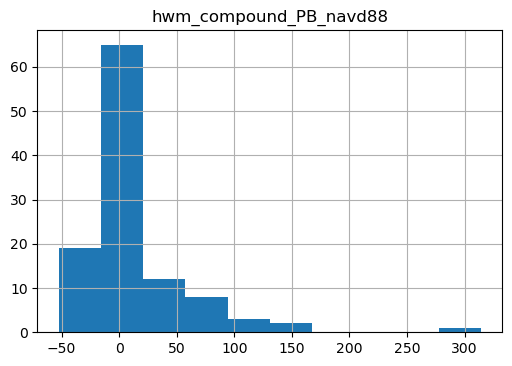

In [62]:
val_riv.hist(
    column = [
        'hwm_compound_PB_navd88',
        # 'hwm_riv_PB_navd88',
        # 'hwm_surge_PB_navd88'
    ],
    )

<AxesSubplot:>

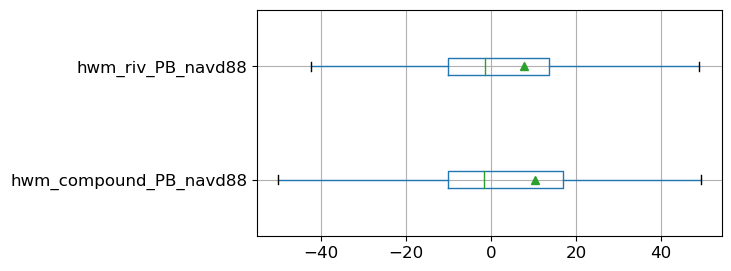

In [63]:
val_riv.boxplot(
    column = [
        'hwm_compound_PB_navd88',
        'hwm_riv_PB_navd88',
        # 'hwm_surge_PB_navd88'
    ],
    showmeans = True,
    showfliers = False,
    vert = False,
    fontsize = 12,
    figsize=(6,3)
    )

array([[<AxesSubplot:title={'center':'pwl_compound_PB_navd88'}>]],
      dtype=object)

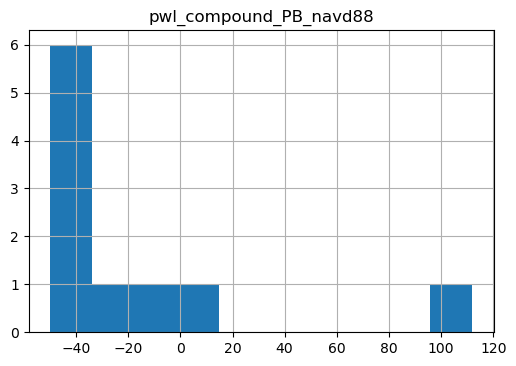

In [64]:
val_surge.hist(
    column = [
        'pwl_compound_PB_navd88',
        # 'pwl_riv_PB_navd88',
        # 'pwl_surge_PB_navd88'
    ],
    )

<AxesSubplot:>

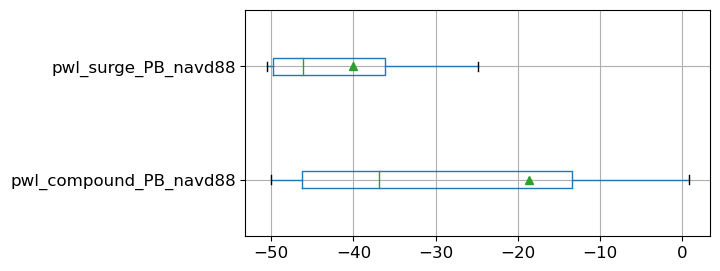

In [65]:
val_surge.boxplot(
    column = [
        'pwl_compound_PB_navd88',
        # 'pwl_riv_PB_navd88',
        'pwl_surge_PB_navd88'
    ],
    showmeans = True,
    showfliers = False,
    vert = False,
    fontsize = 12,
    figsize=(6,3)
    )